In [43]:
import matplotlib.pyplot as plt
import numpy as np

from landlab import HexModelGrid, RasterModelGrid
from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    FlowAccumulator,
    SteepnessFinder,
    StreamPowerEroder,
    LinearDiffuser
)

from landlab.plot import imshow_grid

%matplotlib inline

# Simple example using Linear Diffuser & Stream Power components
No uplift,
not considering precipitation

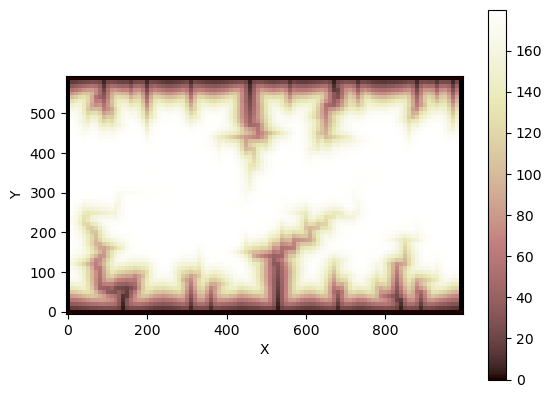

In [47]:
# PARAMS
K = 0.0005  # stream power coefficient, bigger = streams erode more quickly
U = 0.0004  # uplift rate in meters per year

dt = 1000  # time step in years
dx = 10  # space step in meters

nr = 60  # number of model rows
nc = 100  # number of model columns

# Original K_sp value is 1e-5
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

D = 0.001  # Hillslope diffusivity and m2 per years


#create grid
grid = RasterModelGrid((nr, nc), xy_spacing=dx)
grid.set_closed_boundaries_at_grid_edges(True, False, True, False)
# add a topographic__elevation field with noise
z = grid.add_zeros("topographic__elevation", at="node")
z[grid.core_nodes] += 100.0 + np.random.randn(grid.core_nodes.size)

#imshow_grid(grid, "topographic__elevation")

# initializing flow accumulator
fr = FlowAccumulator(grid, depression_finder="DepressionFinderAndRouter", routing="D4")

# initializing stream power incision
spr = StreamPowerEroder(
    grid, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0
)  

# initializing linear diffuser
dd = LinearDiffuser(
    grid,
    linear_diffusivity=D,
)

# Run this model for multiple iterations
for i in range(200):
    # Flow Accumulator
    fr.run_one_step()
    # Stream Power
    spr.run_one_step(dt)
    # linear Diffuser
    dd.run_one_step(dt)

    #z[grid.core_nodes] += U * dt

# plot the final topography
imshow_grid(grid, "topographic__elevation")

Vary diffusivity spatially

In [ ]:
# PARAMS
K = 0.0005  # stream power coefficient, bigger = streams erode more quickly
U = 0.0004  # uplift rate in meters per year

dt = 1000  # time step in years
dx = 10  # space step in meters

nr = 60  # number of model rows
nc = 100  # number of model columns

# Original K_sp value is 1e-5
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

D = 0.001  # Hillslope diffusivity and m2 per years


# rate of EQs
rate = np.array([0, 0, 0.01, 0.01, 0, 0, 0.01, 0.01, 0, 0, 0.01, 0.01, 0])


#create grid
grid = RasterModelGrid((nr, nc), xy_spacing=dx)
grid.set_closed_boundaries_at_grid_edges(True, False, True, False)
# add a topographic__elevation field with noise
z = grid.add_zeros("topographic__elevation", at="node")
z[grid.core_nodes] += 100.0 + np.random.randn(grid.core_nodes.size)

#imshow_grid(grid, "topographic__elevation")

# initializing flow accumulator
fr = FlowAccumulator(grid, depression_finder="DepressionFinderAndRouter", routing="D4")

# initializing stream power incision
spr = StreamPowerEroder(
    grid, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0
)  

# initializing linear diffuser
dd = LinearDiffuser(
    grid,
    linear_diffusivity=D,
)

# Run this model for multiple iterations
for i in range(200):
    # Flow Accumulator
    fr.run_one_step()
    # Stream Power
    spr.run_one_step(dt)
    # linear Diffuser
    dd.run_one_step(dt)

    #z[grid.core_nodes] += U * dt

# plot the final topography
imshow_grid(grid, "topographic__elevation")

# Linear Diffuser example with varying k

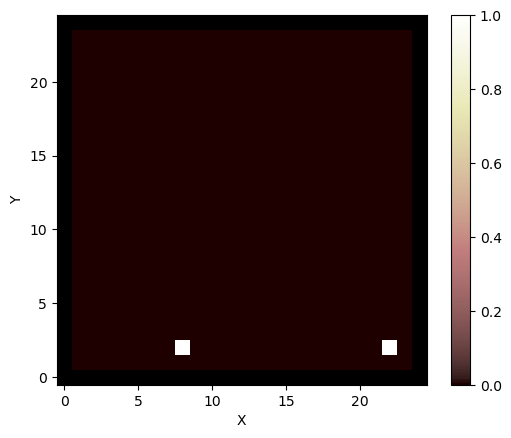

In [60]:
from landlab import RasterModelGrid
import numpy as np

mg2 = RasterModelGrid((25, 25))
z2 = mg2.add_zeros("topographic__elevation", at="node")
z2.reshape((25, 25))[2, 8] = 1.
z2.reshape((25, 25))[2, 22] = 1.
mg2.set_closed_boundaries_at_grid_edges(True, True, True, True)
imshow_grid(mg2,"topographic__elevation")

[ 0.          0.08333333  0.16666667  0.25        0.33333333  0.41666667
  0.5         0.58333333  0.66666667  0.75        0.83333333  0.91666667
  1.          1.08333333  1.16666667  1.25        1.33333333  1.41666667
  1.5         1.58333333  1.66666667  1.75        1.83333333  1.91666667
  2.          0.          0.08333333  0.16666667  0.25        0.33333333
  0.41666667  0.5         0.58333333  0.66666667  0.75        0.83333333
  0.91666667  1.          1.08333333  1.16666667  1.25        1.33333333
  1.41666667  1.5         1.58333333  1.66666667  1.75        1.83333333
  1.91666667  2.          0.          0.08333333  0.16666667  0.25
  0.33333333  0.41666667  0.5         0.58333333  0.66666667  0.75
  0.83333333  0.91666667  1.          1.08333333  1.16666667  1.25
  1.33333333  1.41666667  1.5         1.58333333  1.66666667  1.75
  1.83333333  1.91666667  2.          0.          0.08333333  0.16666667
  0.25        0.33333333  0.41666667  0.5         0.58333333  0.66666667
  

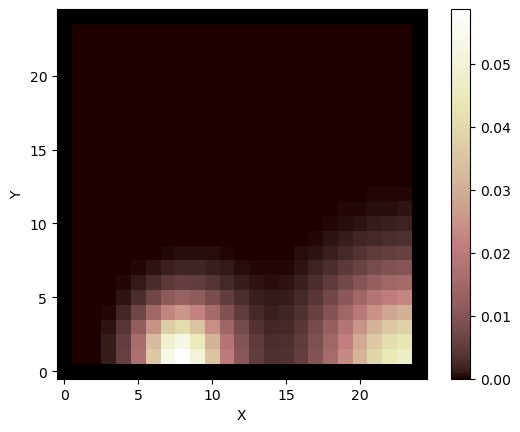

In [63]:
#print(mg2.node_x)
#print(mg2.node_x.mean())
kd = mg2.node_x/mg2.node_x.mean()

print(kd)

ld2 = LinearDiffuser(mg2, linear_diffusivity=kd)
for i in range(10):
    ld2.run_one_step(0.1)
z2[mg2.core_nodes].sum() == 2.

z2.reshape((25, 25))[2, 8] > z2.reshape((25, 25))[2, 22]
imshow_grid(mg2, "topographic__elevation")

# Include Precipitation

In [ ]:
# precipitation increase w/ elevation by factor of 3
# P0 = 80 (reference precipitation rate) 


